In [2]:
import os
import numpy as np
import pandas as pd
import pvlib #For simulation of PV performance 
import matplotlib.pyplot as plt
import pathlib 
from pvlib.pvsystem import PVSystem

## Data ranges from 01.09.2021 to 31.08.2022 for location 59°31’52.54″N 12°37’14.78″E (GEC)


In [4]:
#Reading the dataset 

pv = r'D:\jlabs_dev\pv_model\pv_simulation\59.53122_12.62012_PVsyst_PT60M.csv'
#raw string notation is used to indicate the file path of the csv file

pv_data = pd.read_csv(pv, comment='#', skiprows=[10]) 

pv_data.index = pd.to_datetime(pv_data[['Year', 'Month', 'Day', 'Hour', 'Minute']])
# index is used to identify and access the rows of the DataFrame
# convert a column of data in a DataFrame to a datetime data type

pv_data = pv_data.tz_localize('UTC') 
#the time zone is set to 'UTC', which stands for Coordinated Universal Time

In [5]:
pv_data.head(5) #getting the first five rows of dataset

,Year,Month,Day,Hour,Minute,Tamb,Cloudopacity,DHI,DNI,GHI,WindVel
2021-09-01 00:00:00+00:00,2021,9,1,0,0,9.7,88.1,0,0,0,1.9
2021-09-01 01:00:00+00:00,2021,9,1,1,0,9.3,55.6,0,0,0,1.8
2021-09-01 02:00:00+00:00,2021,9,1,2,0,9.0,57.5,0,0,0,1.8
2021-09-01 03:00:00+00:00,2021,9,1,3,0,8.7,48.1,0,0,0,1.7
2021-09-01 04:00:00+00:00,2021,9,1,4,0,8.8,48.5,12,4,13,1.5


In [6]:
#checking the number of rows and columns in dataset

print("Number of rows:", len(pv_data))
print("Number of columns:", len(pv_data.columns))

Number of rows: 8760
Number of columns: 11


In [7]:
pv_data.keys() #data features that we have in our dataset

Index(['Year', 'Month', 'Day', 'Hour', 'Minute', 'Tamb', 'Cloudopacity', 'DHI',
       'DNI', 'GHI', 'WindVel'],
      dtype='object')

# Data Exploration

### We are going to focus on the features that are important for PV modeling among the multiple columns present in the dataset.

In [8]:
data = pv_data[['GHI', 'DHI', 'DNI', 'Tamb', 'WindVel']]
data.head(5)

,GHI,DHI,DNI,Tamb,WindVel
2021-09-01 00:00:00+00:00,0,0,0,9.7,1.9
2021-09-01 01:00:00+00:00,0,0,0,9.3,1.8
2021-09-01 02:00:00+00:00,0,0,0,9.0,1.8
2021-09-01 03:00:00+00:00,0,0,0,8.7,1.7
2021-09-01 04:00:00+00:00,13,12,4,8.8,1.5


### Plotting irradiance data for better understanding of data set

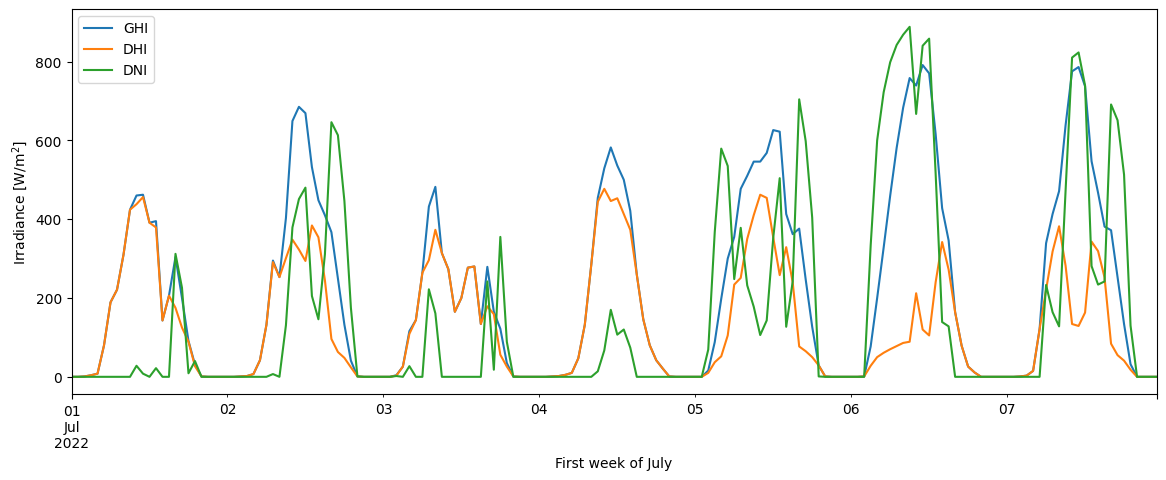

In [9]:
#we are plotting the irradiance data for the first week of july 

dec=data.loc['2022-07-01':'2022-07-07']
dec[['GHI', 'DHI', 'DNI']].plot(figsize=(14,5))
plt.ylabel('Irradiance [W/m$^2$]');
plt.xlabel('First week of July');

#from below graph we can conclude that DNI is highest in most of the days, 
#due to seasonal variation GHI is more than DNI


### Irradiance pattern for a single day.

Text(0.5, 0, 'Time')

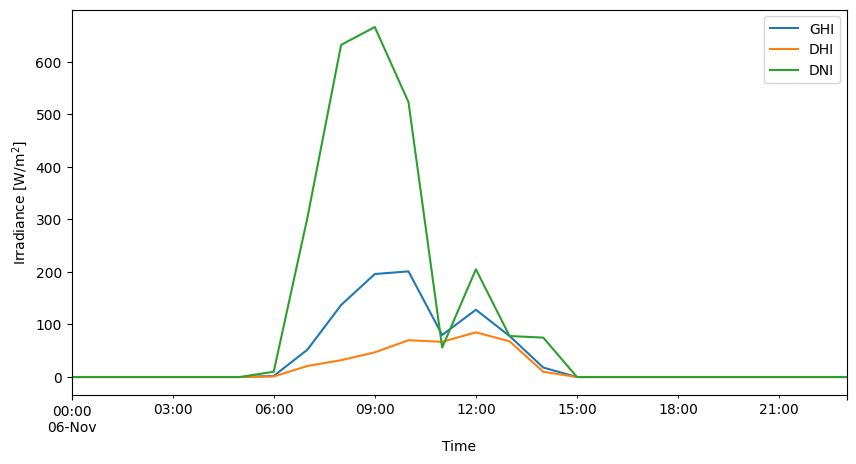

In [10]:
#irradiance pattern in winter

single_day_w=data.loc['2021-11-06']
single_day_w[['GHI', 'DHI', 'DNI']].plot(figsize=(10,5))
plt.ylabel('Irradiance [W/m$^2$]');
plt.xlabel('Time')


DNI is typically greater than GHI because the direct rays of the sun are more intense than the scattered and reflected radiation that contributes to GHI. When the sun's rays pass through the atmosphere, they are scattered by air molecules, water vapor, and other particles. This scattered radiation contributes to GHI, but it reduces the amount of direct radiation that reaches the surface.

Text(0.5, 0, 'Time')

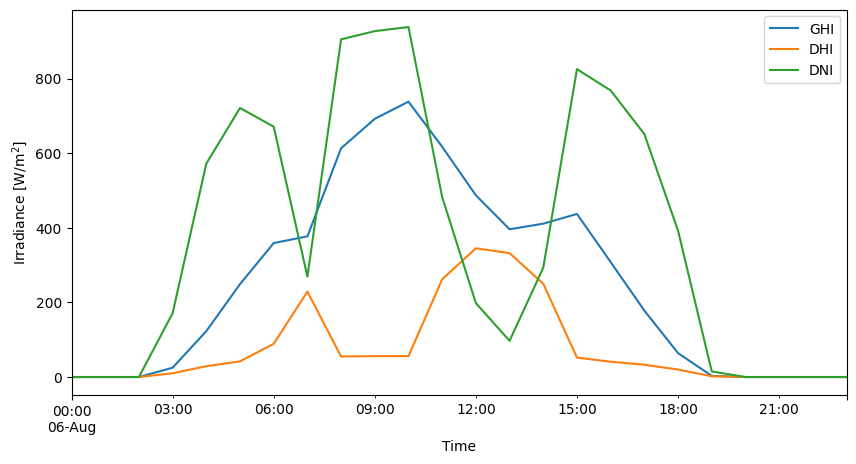

In [11]:
#irradiance pattern in summer

single_day_s=data.loc['2022-08-06']
single_day_s[['GHI', 'DHI', 'DNI']].plot(figsize=(10,5))
plt.ylabel('Irradiance [W/m$^2$]');
plt.xlabel('Time')

#In winter, the sun is at a lower angle in the sky, which increases the
#amount of atmospheric scattering and increases the amount of diffuse radiation reaching the surface. 

### Irradiance trend at time interval of 4 hours.

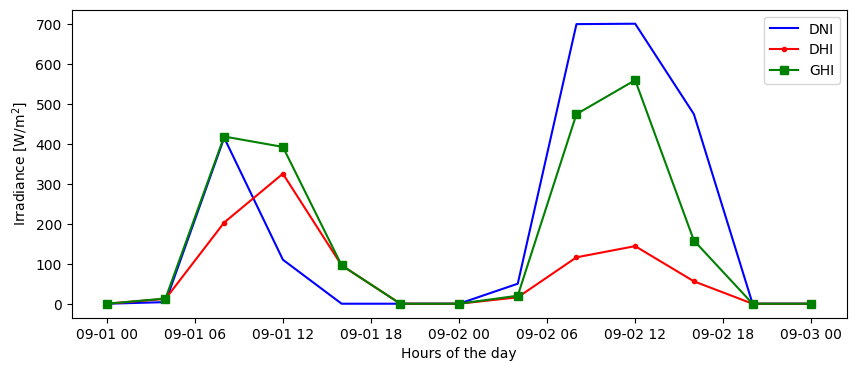

In [12]:
interval = data.iloc[[0,4,8,12,16,20,24,28,32,36,40,44,48]]
plt.figure(figsize=(10,4))
plt.plot(interval['DNI'], color='b',label='DNI') 
plt.plot(interval['DHI'], color='r', marker='.',label='DHI') 
plt.plot(interval['GHI'], color='g', marker='s',label='GHI') 
plt.ylabel('Irradiance [W/m$^2$]');
plt.xlabel('Hours of the day')
plt.legend()

#From the below graphs we conclude that the DHI is always lower than DNI and GHI

##### GHI: Global Horizontal Irradiance; the total sunlight intensity falling on a horizontal plane

##### DHI: Diffuse Horizontal Irradiance; the subset of sunlight falling on a horizontal plane that isn’t coming directly from the sun (e.g., the light that makes the sky blue)

##### DNI: Direct Normal Irradiance; the subset of sunlight coming directly from the sun


#### GHI (Global Horizontal Irradiance) is the total amount of solar radiation received by a horizontal surface. It is measured in units of watts per square meter (W/m²) and includes both direct and diffuse radiation.

#### DNI (Direct Normal Irradiance) is the amount of solar radiation that is received by a surface that is directly facing the sun. It is also measured in units of watts per square meter (W/m²) and only includes the direct radiation component.

#### DHI (Diffuse Horizontal Irradiance) is the amount of solar radiation that is received by a horizontal surface after the direct radiation component has been removed. It is measured in units of watts per square meter (W/m²) and only includes the diffuse radiation component.

#### Temperature trend from January to August.

Text(0.5, 0, 'October')

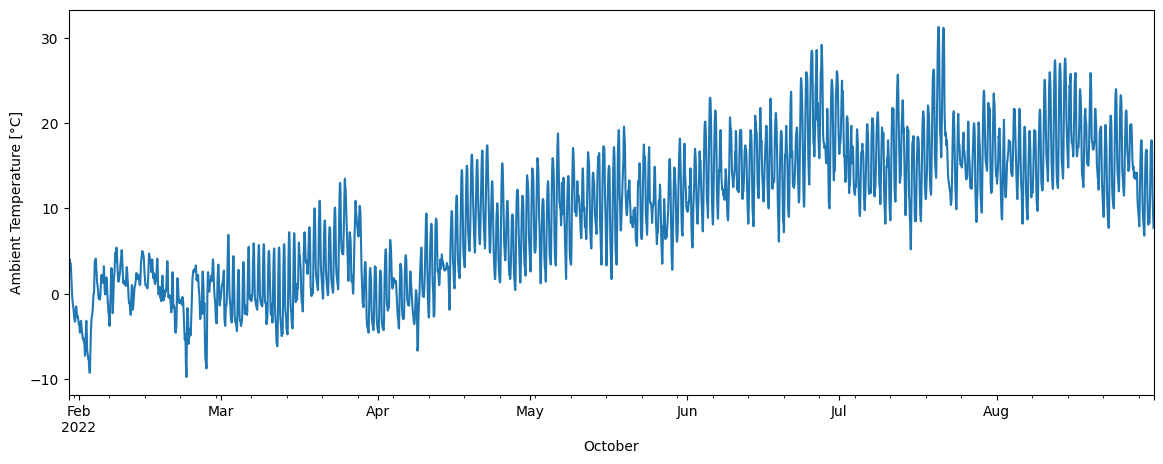

In [13]:
temp=data.loc['2022-01-30':'2022-08-31']['Tamb'].plot(figsize=(14,5))
plt.ylabel('Ambient Temperature [°C]');
plt.xlabel('October')

#### Wind velocity trend in the month of June 

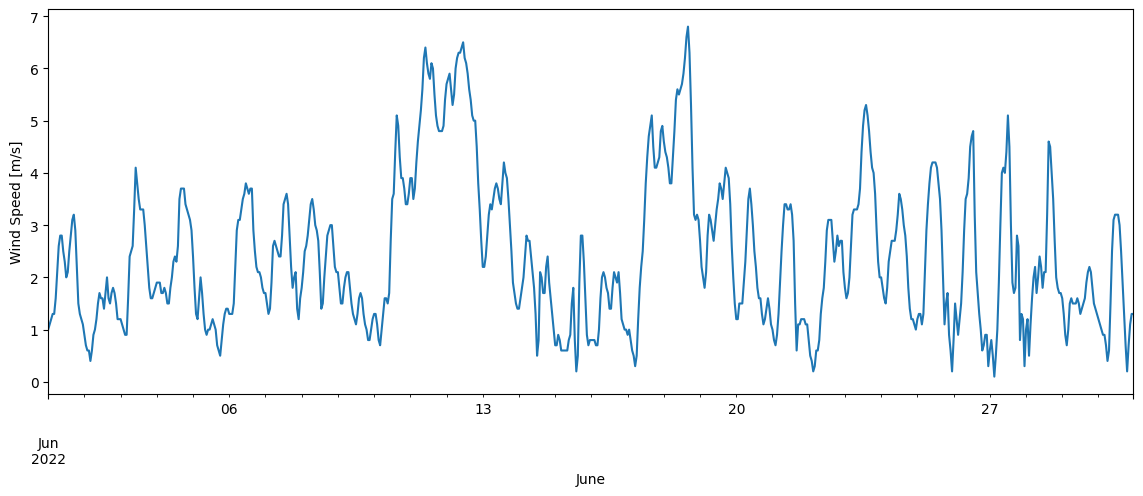

In [14]:
wind=data.loc['2022-06-01':'2022-06-30']['WindVel'].plot(figsize=(14,5))
plt.ylabel('Wind Speed [m/s]');
plt.xlabel('June');

#### Calculating the monthly average GHI to get the trend of GHI through the whole year 

C:\Users\suraj\AppData\Local\Temp\ipykernel_376\2159311322.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ghi_month=data['GHI'].resample('M').sum()


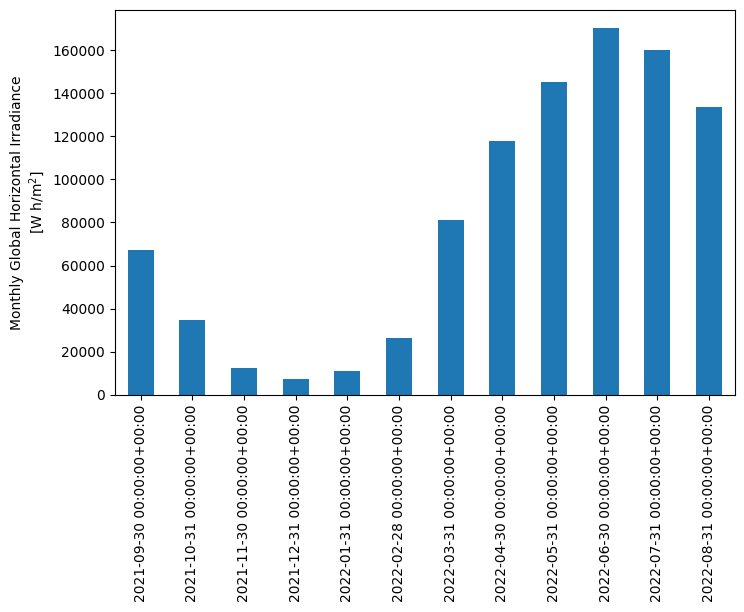

In [15]:
plt.figure(figsize=(8,5))

#Applying resample function on the data set with date offset function 'M'
#Resampling generates a unique sampling distribution on the basis of the actual data.

ghi_month=data['GHI'].resample('M').sum() 
ghi_month.plot.bar()
plt.ylabel('Monthly Global Horizontal Irradiance\n[W h/m$^2$]');

#From the below graph we can conclude that the GHI was maximum in the month of june 2022 and min in dec 

#### Visualizing the trend for average daily DNI. 

C:\Users\suraj\AppData\Local\Temp\ipykernel_376\631365572.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_average_DNI = data[['DNI']].resample('M').mean()


Text(0.5, 0, 'Month of the Year')

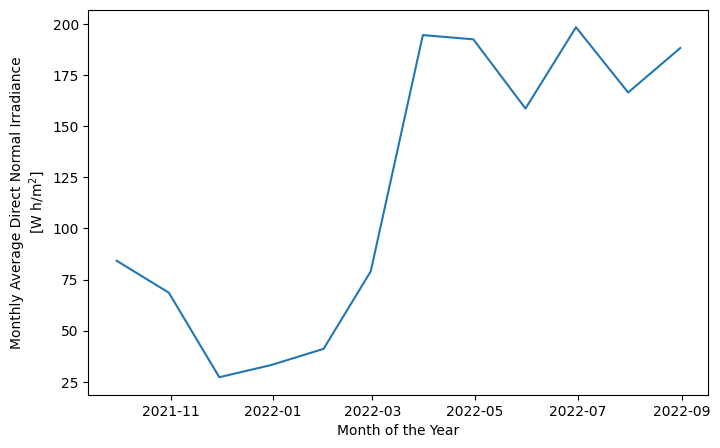

In [16]:
monthly_average_DNI = data[['DNI']].resample('M').mean()  
plt.figure(figsize=(8,5))
plt.plot(monthly_average_DNI)
plt.ylabel('Monthly Average Direct Normal Irradiance\n[W h/m$^2$]')
plt.xlabel('Month of the Year')

## POA Irradiance 

#### Plane of array irradiance refers to the amount of solar radiation (i.e. sunlight) that is received by the surface of a solar panel or array of solar panels. It is typically measured in units of watts per square meter (W/m^2) and is affected by factors such as the angle of the sun, the amount of cloud cover, and the location of the solar panel. The optimal plane of array irradiance for a solar panel is when it is perpendicular to the sun's rays, as this allows the panel to receive the most amount of sunlight possible.

#### Transforming the GHI,DHI and DNI in to the main POA component because main solar radiation is POA that is imapcting the specific surface that is solar panel

#### We need to calculate solar positions first to get the POA irradiance

In [17]:
#Now we will transform the three irradiance in to the POA irradiance which is most impt irradiance for our PV system 
#Transposition  - It is the calculation of incident irradiance on a tilted plane from horizontal irradiance data 
#Calculating the POA from GHI, DNI and DHI
#Below are the geo point for GEC 

location = pvlib.location.Location(latitude=59.53122, longitude=12.62012) 

# Time interval in the dataset is 1 hour, data gives us the average weather condition of each hour
# 09AM to 10AM interval is labeled 10.  We will calculate solar position in
# the middle of the interval (09:30), so we subtract 30 minutes

times = data.index - pd.Timedelta('30min')

# function helps to calculate the solar zenith, azimuth, etc. at this location.

solar_position = location.get_solarposition(times) 

# shifting the index back to line up with the dataset:

solar_position.index = solar_position.index + pd.Timedelta('30min')
solar_position.head()

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time
2021-09-01 00:00:00+00:00,112.065142,112.065142,-22.065142,-22.065142,5.445373,-0.081664
2021-09-01 01:00:00+00:00,110.323616,110.323616,-20.323616,-20.323616,21.265943,-0.068487
2021-09-01 02:00:00+00:00,106.669685,106.669685,-16.669685,-16.669685,36.447631,-0.055301
2021-09-01 03:00:00+00:00,101.442840,101.442840,-11.442840,-11.442840,50.781438,-0.042107
2021-09-01 04:00:00+00:00,95.047176,95.047176,-5.047176,-5.047176,64.329278,-0.028905


#### Zenith (How close the sun is to overhead) and Azimuth (what direction along the horizon the sun is, like panel azimuth). 
#### Apparent_zenith is with effect of atmosphere and zenith is without effect of atmosphere

In [18]:
#Our PV array is facing south (azimuth = 180) with fixed tilt angle of 40 degree

#There are multiple models for calculation we are going to use the default model=isotropic
#some complex models that requires more weather inputs. Perez and Hay Davies models are examples.

poa_irr = pvlib.irradiance.get_total_irradiance(surface_tilt=40,surface_azimuth=180,dni=data['DNI'],
                                                ghi=data['GHI'],
                                                dhi=data['DHI'],
                                                solar_zenith=solar_position['apparent_zenith'],
                                                solar_azimuth=solar_position['azimuth'],
                                                model='isotropic') 
poa_irr[0:23]


# Below are the values of POA for a single day 
# In below dataframe we got the POA components of all irradiance 

,poa_global,poa_direct,poa_diffuse,poa_sky_diffuse,poa_ground_diffuse
2021-09-01 00:00:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000
2021-09-01 01:00:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000
2021-09-01 02:00:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000
2021-09-01 03:00:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000
2021-09-01 04:00:00+00:00,10.976444,0.000000,10.976444,10.596267,0.380178
2021-09-01 05:00:00+00:00,75.244533,0.000000,75.244533,72.407822,2.836711
2021-09-01 06:00:00+00:00,158.044181,35.256181,122.788000,116.558933,6.229067
2021-09-01 07:00:00+00:00,316.011764,191.924831,124.086933,113.909867,10.177067
2021-09-01 08:00:00+00:00,434.077311,242.599623,191.477689,179.253511,12.224178
2021-09-01 09:00:00+00:00,608.149549,430.671061,177.478489,162.476089,15.002400


In [19]:
#At this 10:00 we are getting the max poa global

poa_irr.poa_global['2021-09-01 10:00:00+00:00']

np.float64(645.8261153265648)

#### Effective irradiance
#### Plane of array (POA) irradiance is the amount of solar radiation that falls on a surface perpendicular to the sun's rays. Effective irradiance, also known as plane of cell (POC) irradiance, is the amount of solar radiation that falls on a surface at an angle, taking into account the effect of shading and reflections from surrounding surfaces. The POA irradiance is typically higher than the POC irradiance, because the POC irradiance takes into account the reduction in solar radiation due to shading and reflections.

##### An incident angle modifier (IAM) is a model used to adjust the amount of solar irradiance that reaches a solar panel based on the angle at which sunlight strikes the panel. The IAM takes into account the angle of incidence (AOI) of the sun's rays on the panel and modifies the irradiance value based on the specific characteristics of the panel.

In [20]:
#we have to calculate the effective irradiance also for the model.

#AOI is the angle at which sunlight strikes a solar panel and 
#its effect on the panel's power output. 


aoi=pvlib.irradiance.aoi(surface_tilt=40,surface_azimuth=180,
                         solar_zenith=solar_position['apparent_zenith'],
                         solar_azimuth=solar_position['azimuth'])

#Determine the incidence angle modifier using the ASHRAE transmission model.

iam=pvlib.iam.ashrae(aoi)

#effective irradiance 

effective_irradiance=poa_irr['poa_direct'] * iam + poa_irr['poa_diffuse']

effective_irradiance['2021-09-01 10:00:00+00:00']

np.float64(643.3110833184787)

In [21]:
#We will see monthly irradiance to observe the difference between the the amount of irradiance received by a 
#flat panel (GHI) and that of a tilted panel (POA):

C:\Users\suraj\AppData\Local\Temp\ipykernel_376\716676707.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df.resample('M').sum()


Text(0.5, 0, 'Months')

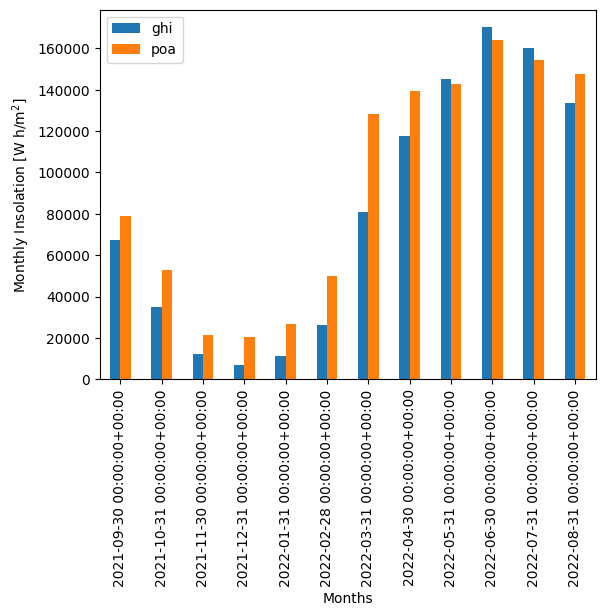

In [22]:
#Total POA irradiance is th poa_global
#visualizing the trend for global irradiance and global poa 

df = pd.DataFrame({'ghi': data['GHI'],'poa': poa_irr['poa_global'],})
df_monthly = df.resample('M').sum()
df_monthly.plot.bar()
plt.ylabel('Monthly Insolation [W h/m$^2$]');
plt.xlabel('Months')

#Here we can conclude that a tilted panel receives more irradiance as compared to a flat panel

#### Why POA is greater than GHI ?

###### POA (Plane of Array) irradiance is a measure of the solar radiation that falls directly on a surface, whereas GHI (Global Horizontal Irradiance) is a measure of the total amount of solar radiation that falls on a horizontal surface.

###### POA is generally greater than GHI because it only takes into account the radiation that is directly hitting the surface, while GHI takes into account all the radiation, including the diffuse radiation that is scattered by the atmosphere. Diffuse radiation can come from all directions, including the sky, and is not as intense as direct radiation.


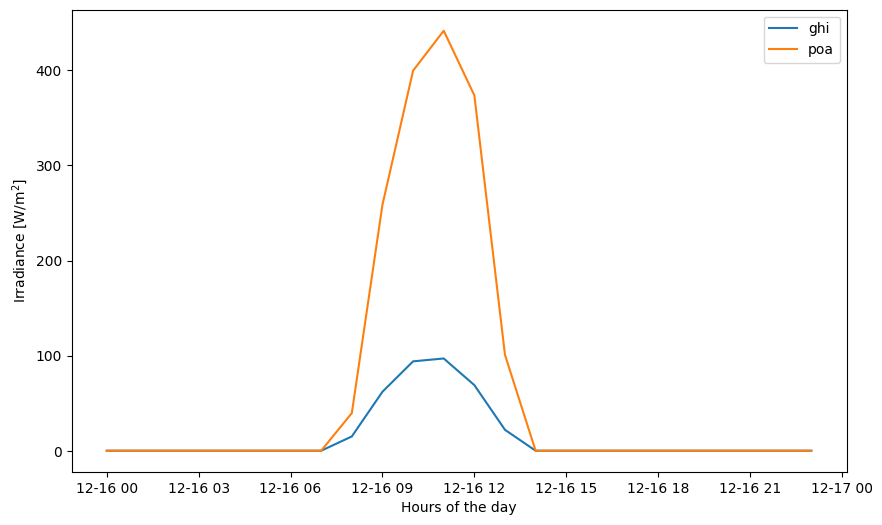

In [23]:
#Visualizing the trend for a single day in winter 

day=df.loc['2021-12-16']
plt.figure(figsize=(10,6))
plt.plot(day)
plt.ylabel('Irradiance [W/m$^2$]');
plt.xlabel('Hours of the day')
plt.legend(['ghi','poa'])

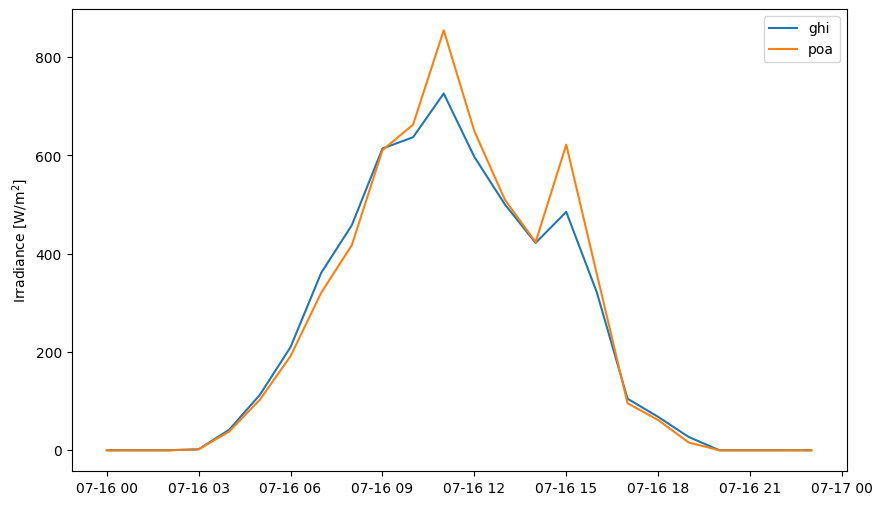

In [24]:
#Visualizing the trend for a single day in summer  

plt.figure(figsize=(10,6))
day_summer =df.loc['2022-07-16']
plt.plot(day_summer)
plt.ylabel('Irradiance [W/m$^2$]');
plt.legend(['ghi','poa'])

#If we compare both the graphs the height and width both are changed that means irradiance and the duration of higher 
#irradiance also increases 

## Estimating the PV cell temp

#### Sandia Array Performance Model (SAPM) estimate cell temperature from ambient conditions. The SAPM thermal model takes POA irradiance, ambient temperature, and wind speed as weather inputs

In [25]:
#sandia Array performance model(sapm) is used to calculate the cell temperature.
#We are considering here open rack structure with polymer backsheet

all_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer']
cell_temperature = pvlib.temperature.sapm_cell(poa_irr['poa_global'],data['Tamb'], 
                                               data['WindVel'],**all_parameters)
cell_temperature.head(5)

2021-09-01 00:00:00+00:00    9.700000
2021-09-01 01:00:00+00:00    9.300000
2021-09-01 02:00:00+00:00    9.000000
2021-09-01 03:00:00+00:00    8.700000
2021-09-01 04:00:00+00:00    9.111872
dtype: float64

#### Comapring the cell temp with the ambient temp for the first week

Text(0.5, 0, 'First week of Sep')

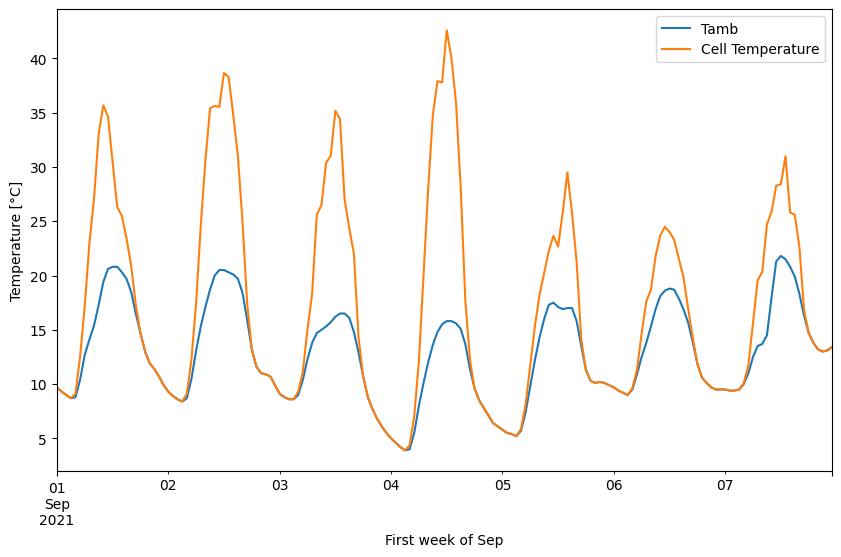

In [26]:
plt.figure(figsize=(10,6))
data['Tamb'].head(24*7).plot()
cell_temperature.head(24*7).plot()
plt.legend(['Tamb', 'Cell Temperature'])
plt.ylabel('Temperature [°C]');
plt.xlabel('First week of Sep') 

#### In the above graph we see that cell temp is more than ambient temperature because of the heat generated by the PV effect.

## PV module and inverter selection from database



In [27]:
#importing the modules and inverter from from database

cec_modules = pvlib.pvsystem.retrieve_sam('CECMod') #database modules
cec_inverters = pvlib.pvsystem.retrieve_sam('cecinverter') #database inverter

PV_module_cec = cec_modules['Innotech_Solar_ITS220Myz3'] #220W moduel


#we dont have the inverter that in used in plant so we will be using the other with same features 
cec_inverter = cec_inverters['Motech_Industries__PVMate_4900U__208V_']

#we dont have the inverter Eltek Valere 4300W in all the database of PVlib 

In [28]:
PV_module_cec

Technology            Mono-c-Si
Bifacial                      0
STC                    220.0716
PTC                       195.4
A_c                       1.616
Length                    1.637
Width                     0.987
N_s                          60
I_sc_ref                   7.85
V_oc_ref                  36.72
I_mp_ref                   7.38
V_mp_ref                  29.82
alpha_sc               0.002355
beta_oc               -0.121176
T_NOCT                     48.1
a_ref                   1.50093
I_L_ref                7.856044
I_o_ref                     0.0
R_s                     0.33224
R_sh_ref             431.529999
Adjust                  6.17748
gamma_r                   -0.45
BIPV                          N
Version       SAM 2018.11.11 r2
Date                   1/3/2019
Name: Innotech_Solar_ITS220Myz3, dtype: object

In [29]:
cec_inverter.head()

Vac             208
Pso        29.78334
Paco         4300.0
Pdco    4506.239258
Vdco          275.0
Name: Motech_Industries__PVMate_4900U__208V_, dtype: object

#### Calculates five parameter values for the single diode equation at effective irradiance and cell temperature using the CEC model

In [30]:
#The five values are returned by calcparams_cec can be used by singlediode to calculate an IV curve.
    

cec_params=pvlib.pvsystem.calcparams_cec(effective_irradiance=effective_irradiance,
                                        temp_cell=cell_temperature,
                                        alpha_sc=PV_module_cec.alpha_sc,
                                        a_ref=PV_module_cec.a_ref,
                                        I_L_ref=PV_module_cec.I_L_ref,
                                        I_o_ref=PV_module_cec.I_o_ref,
                                        R_sh_ref=PV_module_cec.R_sh_ref,
                                        R_s=PV_module_cec.R_s,
                                        Adjust=PV_module_cec.Adjust)

#### alpha_sc : it is the temperature coefficient of the short-circuit current of a photovoltaic (PV) cell or module
#### a_ref : the diode ideality factor at reference condition.
#### I_L_ref : the light-generated current at reference condition.
#### I_o_ref : the reverse saturation current at reference condition.
#### R_s : the series resistance at reference condition.
#### R_sh_ref : the shunt resistance at reference condition.
#### Adjust : the temperature coefficient of the reference current.

###### The single diode equation is a mathematical model used to describe the current-voltage (IV) characteristics of a photovoltaic (PV) cell or module under different operating conditions. It is based on the equivalent circuit of a PV cell, which is composed of a diode and a resistor connected in series. The equation is given as:

##### I = I_ph - I_0*(exp((V + IR_s)/(nV_T)) - 1)

##### Where:

##### I is the current flowing through the cell or module.
##### V is the voltage across the cell or module.
##### I_ph is the photocurrent, which is the current flowing through the cell or module when it is illuminated by light.
##### I_0 is the reverse saturation current, which is the current flowing through the diode when the voltage across it is zero.
##### R_s is the series resistance, which represents the resistance of the cell or module.
##### n is the diode ideality factor, which is a measure of the quality of the diode.
##### V_T is the thermal voltage, which is a measure of the energy per electron in the PV cell or module.

##### This equation is an empirical model that describes the behavior of a PV cell or module.It is widely used to model the performance of PV cells and modules under different operating conditions, such as temperature, light intensity, and shading. It can also be used to estimate the power and energy production of a PV system.






##### The above function  has calcuated the following parameters for single diode equation

#### photocurrent : numeric Light-generated current in amperes
#### saturation_current : numeric Diode saturation curent in amperes
#### resistance_series : float Series resistance in ohms
#### resistance_shunt : numeric Shunt resistance in ohms
#### nNsVth : numeric The product of the usual diode ideality factor (n, unitless), number of cells in series (Ns), and cell thermal voltage at specified effective irradiance and cell temperature.
        

In [31]:
#pvlib.pvsystem.max_power_point is a function in the Python library PVLIB 
#that is used to find the maximum power point (MPP) of a photovoltaic (PV) system.

#Given the single diode equation coefficients, calculates the maximum power point (MPP).

#max_power_point(photocurrent, saturation_current, resistance_series, 
#resistance_shunt, nNsVth, d2mutau=0, NsVbi=inf, method='brentq')
#We want to find out max power point that is why we are using the newton method
#'bretq' is used whne you want to find the additional curve in the IV curve

mpp=pvlib.pvsystem.max_power_point(*cec_params,method='newton')
mpp[10:15]

,i_mp,v_mp,p_mp
2021-09-01 10:00:00+00:00,4.752478,28.545829,135.663422
2021-09-01 11:00:00+00:00,4.255328,28.668134,121.992321
2021-09-01 12:00:00+00:00,3.002191,29.102136,87.370176
2021-09-01 13:00:00+00:00,1.715655,29.250019,50.182932
2021-09-01 14:00:00+00:00,1.561377,29.276628,45.711867


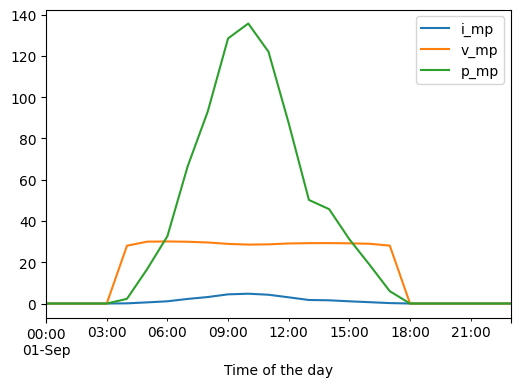

In [32]:
#plotting the trend of imp vmp and pmp

single_day=mpp.head(24)
single_day.plot(figsize=(6,4))
plt.xlabel('Time of the day');

### PV system

In [33]:
#Now we will create our pvsystem in which there are 20 modules per string
#here we can change the modules per string and strings per inverter

system=PVSystem(modules_per_string=20,strings_per_inverter=1,surface_tilt=40)

In [34]:
system

PVSystem:
  name: None
  Array:
    name: None
    mount: FixedMount(surface_tilt=40, surface_azimuth=180, racking_model=None, module_height=None)
    module: None
    albedo: 0.25
    module_type: None
    temperature_model_parameters: {}
    strings: 1
    modules_per_string: 20
  inverter: None

In [35]:
#using the single diode equation to calculate the dc output parameteres
#current at maximum power point in amperes, voltage at maximum power point in volts.
#power at maximum power point in watts 

dc_result=pvlib.pvsystem.singlediode(*cec_params,method='newton')
dc_result[11:15]

,i_sc,v_oc,i_mp,v_mp,p_mp,i_x,i_xx
2021-09-01 11:00:00+00:00,4.533320,34.621001,4.255328,28.668134,121.992321,4.510068,3.188875
2021-09-01 12:00:00+00:00,3.191315,34.641379,3.002191,29.102136,87.370176,3.174960,2.309232
2021-09-01 13:00:00+00:00,1.820712,34.348845,1.715655,29.250019,50.182932,1.811461,1.355793
2021-09-01 14:00:00+00:00,1.656556,34.319562,1.561377,29.276628,45.711867,1.648146,1.238115


In [36]:
#as we know out dc_reuslt is for single module now we will scale our system
#this function Scales the voltage, current, and power of the DataFrame

dc_result_scaled=system.scale_voltage_current_power(dc_result)
p_mp_dc=dc_result_scaled['p_mp']
p_mp_dc[10:15]

2021-09-01 10:00:00+00:00    2713.268432
2021-09-01 11:00:00+00:00    2439.846416
2021-09-01 12:00:00+00:00    1747.403510
2021-09-01 13:00:00+00:00    1003.658642
2021-09-01 14:00:00+00:00     914.237341
Name: p_mp, dtype: float64

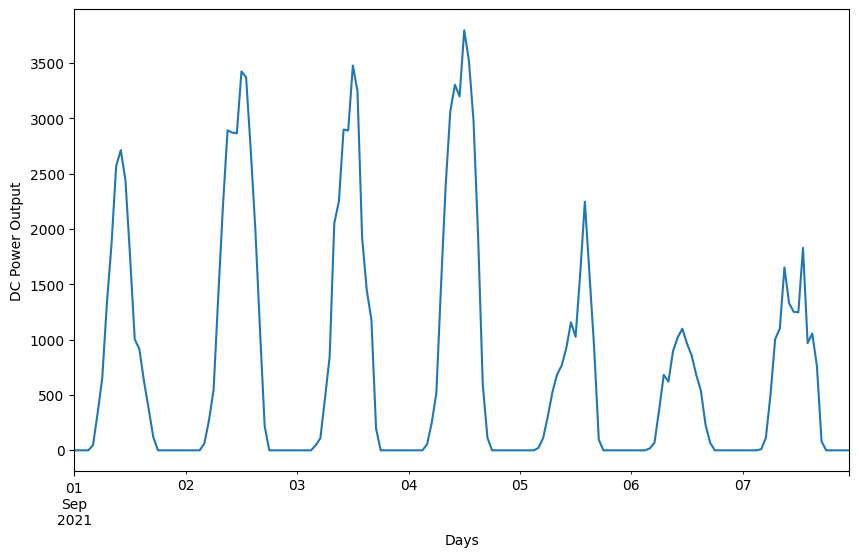

In [37]:
#plotting the dc output for a week

p_mp_dc_single_day=p_mp_dc.head(24*7)
p_mp_dc_single_day.plot(figsize=(10,6))
plt.xlabel('Days');
plt.ylabel('DC Power Output');


In [38]:
cec_inverter.head()

Vac             208
Pso        29.78334
Paco         4300.0
Pdco    4506.239258
Vdco          275.0
Name: Motech_Industries__PVMate_4900U__208V_, dtype: object

##### But in our case we need to feed the info manually as it is not in the database

##### For Eltek Valere 4300W

 
        

##### pdc0: numeric, DC input limit of the inverter. which is 4900Wp in our case.
##### eta_inv_nom: numeric, default 0.96 but in our case we have 97.7%
##### Nominal inverter efficiency. eta_inv_ref: numeric, default 0.9637
##### Reference inverter efficiency. PVWatts defines it to be 0.9637 and is included here for flexibility.

In [39]:
#Calculating the ac_power from PV watts model
#pdc0 from datasheet is 4900W
#eta_inv_nom=0.97,
#eta_inv_ref=0.9637


ac_result=pvlib.inverter.pvwatts(dc_result_scaled.p_mp,
                                 pdc0=4900,
                                 eta_inv_nom=0.97,
                                 eta_inv_ref=0.9637) 

ac_result.head(5)

2021-09-01 00:00:00+00:00     0.000000
2021-09-01 01:00:00+00:00     0.000000
2021-09-01 02:00:00+00:00     0.000000
2021-09-01 03:00:00+00:00     0.000000
2021-09-01 04:00:00+00:00    15.943032
Name: p_mp, dtype: float64

Text(0, 0.5, 'AC Power Output')

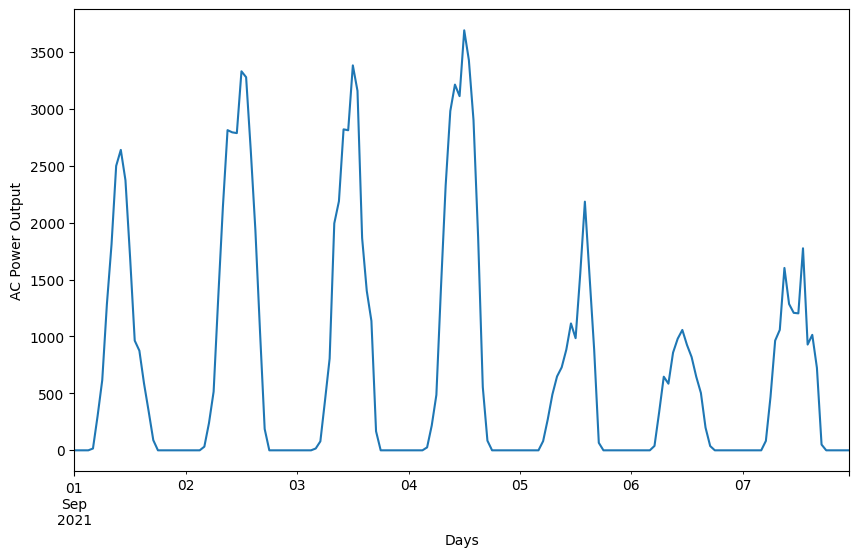

In [40]:
#plotting the trend for a week

single_day=ac_result.head(24*7)
single_day.plot(figsize=(10,6))
plt.xlabel('Days');
plt.ylabel('AC Power Output')

Text(0, 0.5, 'Power Output')

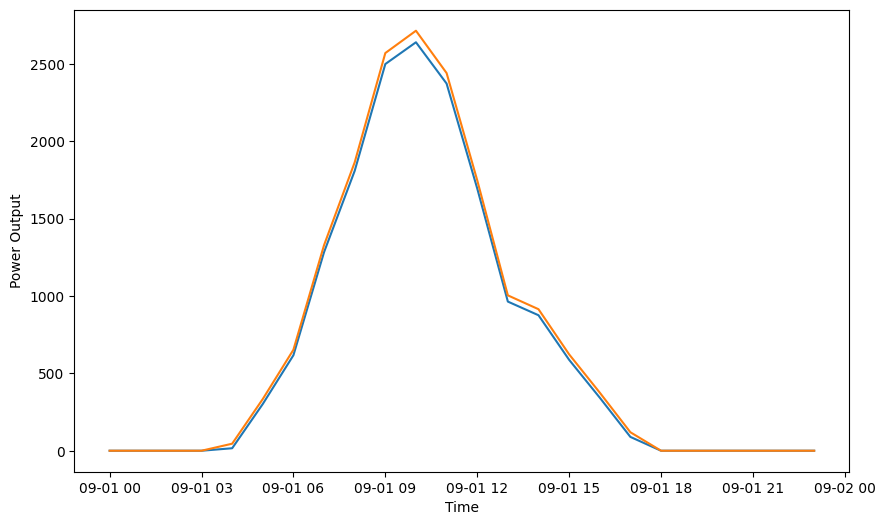

In [41]:
#Comparing ac and dc output for single day

plt.figure(figsize=(10,6))
plt.plot(ac_result.head(24))
plt.plot(p_mp_dc_single_day.head(24))
plt.xlabel('Time');
plt.ylabel('Power Output')

In [42]:
#We got the hourly ac power output for a PV system with 20 modules connected to an inverter

ac_result.head(24)

2021-09-01 00:00:00+00:00       0.000000
2021-09-01 01:00:00+00:00       0.000000
2021-09-01 02:00:00+00:00       0.000000
2021-09-01 03:00:00+00:00       0.000000
2021-09-01 04:00:00+00:00      15.943032
2021-09-01 05:00:00+00:00     301.976862
2021-09-01 06:00:00+00:00     616.904065
2021-09-01 07:00:00+00:00    1282.913385
2021-09-01 08:00:00+00:00    1808.029593
2021-09-01 09:00:00+00:00    2498.028276
2021-09-01 10:00:00+00:00    2638.628407
2021-09-01 11:00:00+00:00    2372.015619
2021-09-01 12:00:00+00:00    1694.591513
2021-09-01 13:00:00+00:00     963.423618
2021-09-01 14:00:00+00:00     875.266536
2021-09-01 15:00:00+00:00     587.402404
2021-09-01 16:00:00+00:00     342.859512
2021-09-01 17:00:00+00:00      89.272430
2021-09-01 18:00:00+00:00       0.000000
2021-09-01 19:00:00+00:00       0.000000
2021-09-01 20:00:00+00:00       0.000000
2021-09-01 21:00:00+00:00       0.000000
2021-09-01 22:00:00+00:00       0.000000
2021-09-01 23:00:00+00:00       0.000000
Name: p_mp, dtyp

In [ ]:
help(pvlib.inverter.pvwatts)